<a href="https://colab.research.google.com/github/svish8791/ardupilot_wiki/blob/master/Sergey_Shishkin/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%BC%D0%B0%D1%80%D1%88%D1%80%D1%83%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Создаем алгоритм построения маршрута посадки.**

Основная идея сокращение пути движения робота за счет движения к месту начала посадки через захватку и выбора направления посадки так, что бы маршрут закончился рядом с точкой выхода.

Задачи:

1. Построение параллельных линий сторонам захватки с заданным отступом (ширина рядков).

2. Получение на параллельных линиях координат точек посадки на заданном интервале друг от друга (частота посадки).

3. Соединение полученных координат в нужной последовательности для получения списка координат движения робота по захватке.

In [6]:
#Устанавливаем необходимые библиотеки

import numpy as np
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import math

In [19]:
#Входные данные
#Координаты захватки в метровой системе координат
ver = [(0.0, 0.0), (281.813489867283, -51.62683398686443), (195.82934770144945, -262.05629291318854), (-558.8559946022785, -222.94167443031805), (-534.9709897381479, -161.9240874697568)]
#Ширина посадки в метрах
distance=5
#Частота посадки в метрах
h = 3
#Координаты точек старта и финиша
start = (190.0, -10.0)
finish = (-331.1, -100.2)

# 1. Задача


<ipython-input-25-2bb81932658f>:10: RuntimeWarning: invalid value encountered in divide
  normal_vector_normalized = normal_vector / np.linalg.norm(normal_vector)


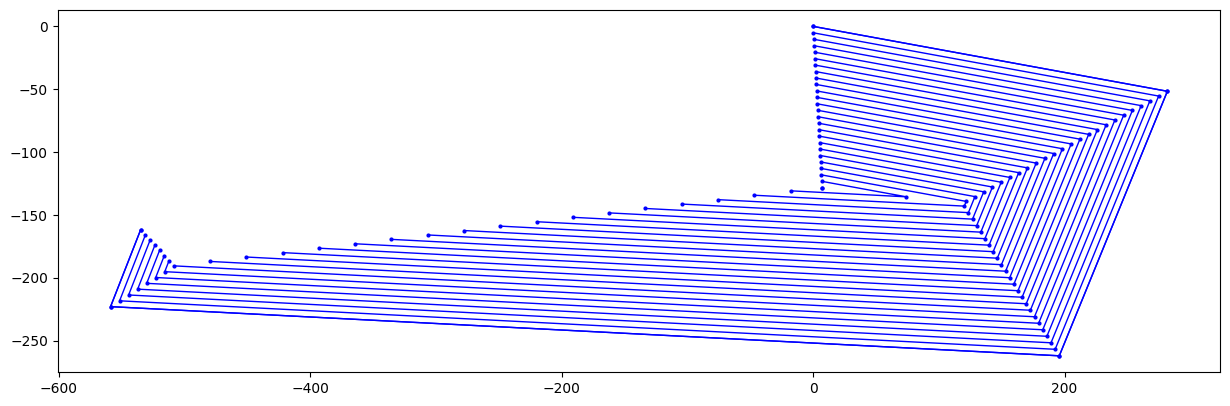

In [25]:
#Функция создания параллельных линий
def create_parallel_line(x1, y1, x2, y2, distance=1.0):
    # Вычисление вектора направления исходной прямой
    direction_vector = np.array([x2 - x1, y2 - y1])

    # Вычисление нормали к прямой
    normal_vector = np.array([direction_vector[1], -direction_vector[0]])

    # Нормализация нормали
    normal_vector_normalized = normal_vector / np.linalg.norm(normal_vector)

    # Вычисление точек на параллельной прямой
    point1_parallel = np.array([x1, y1]) + distance * normal_vector_normalized
    point2_parallel = np.array([x2, y2]) + distance * normal_vector_normalized

    return point1_parallel, point2_parallel

#Функция нахождения точек пересечения линий
def find_intersection_points(polygon, distance=1.0):
    intersection_points = []
    i = -1
    while i < len(polygon.exterior.coords)-1:
        x1, y1 = polygon.exterior.coords[(i-1)% len(polygon.exterior.coords)]
        x2, y2 = polygon.exterior.coords[i]  # Зацикливание
        point1_parallel, point2_parallel = create_parallel_line(x1, y1, x2, y2, distance)

        # Проверяем пересечение с другими параллельными линиями
        x3, y3 = polygon.exterior.coords[(i + 1) % len(polygon.exterior.coords)]
        x4, y4 = polygon.exterior.coords[(i + 2) % len(polygon.exterior.coords)]  # Зацикливание
        point3_parallel, point4_parallel = create_parallel_line(x3, y3, x4, y4, distance)

        # Вычисляем линии для пересечения
        line1 = LineString([point1_parallel, point2_parallel])
        line2 = LineString([point3_parallel, point4_parallel])

        # Находим точку пересечения
        intersection = line1.intersection(line2)
        if intersection.geom_type == 'Point':
            intersection_points.append(intersection.coords[0])
            i += 2  # Переходим к следующей паре линий
        else:
            # Проверяем пересечение с другими параллельными линиями
            x3, y3 = polygon.exterior.coords[i]
            x4, y4 = polygon.exterior.coords[(i + 1) % len(polygon.exterior.coords)]  # Зацикливание
            point3_parallel, point4_parallel = create_parallel_line(x3, y3, x4, y4, distance)

            # Вычисляем линии для пересечения
            line1 = LineString([point1_parallel, point2_parallel])
            line2 = LineString([point3_parallel, point4_parallel])

            # Находим точку пересечения
            intersection = line1.intersection(line2)
            if intersection.geom_type == 'Point':
                intersection_points.append(intersection.coords[0])
            i += 1  # Переходим к следующей линии
    return intersection_points

results1 = [ver]

#Создание внутри полигона нового с параллеьныи сторонами
while len(results1[-1]) >= 3:
    original_polygon = Polygon(results1[-1])
    intersection_points = find_intersection_points(original_polygon, distance)
    results1.append(intersection_points)

# Визуализация (для всех результатов на одном графике)
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot([coord[0] for coord in ver], [coord[1] for coord in ver], marker='o', linestyle='-', color='blue', linewidth=1, markersize=2)
for polygon_coords in results1:
    ax.plot([coord[0] for coord in polygon_coords], [coord[1] for coord in polygon_coords], marker='o', linestyle='-', color='blue', linewidth=1, markersize=2)
ax.set_aspect('equal', 'box')

plt.show()

Маршрут движения получен!

In [21]:
#Добавим к маршруту точки старта и финиша
points_on_perimeter = []
results2 = [results1[-2][0]]
results2.append(start)
results3 = [results1[0][0]]
results3.append(finish)
results1.pop(0)

dx2 = results3[0][0] - results3[1][0]
dy2 = results3[0][1] - results3[1][1]
length_side2 = math.sqrt(dx2**2 + dy2**2)

for j2 in range(0, int(length_side2), 10):
  x = results3[1][0] + (j2 * dx2 / length_side2)
  y = results3[1][1] + (j2 * dy2 / length_side2)
  points_on_perimeter.append((x, y))

# 2. Задача

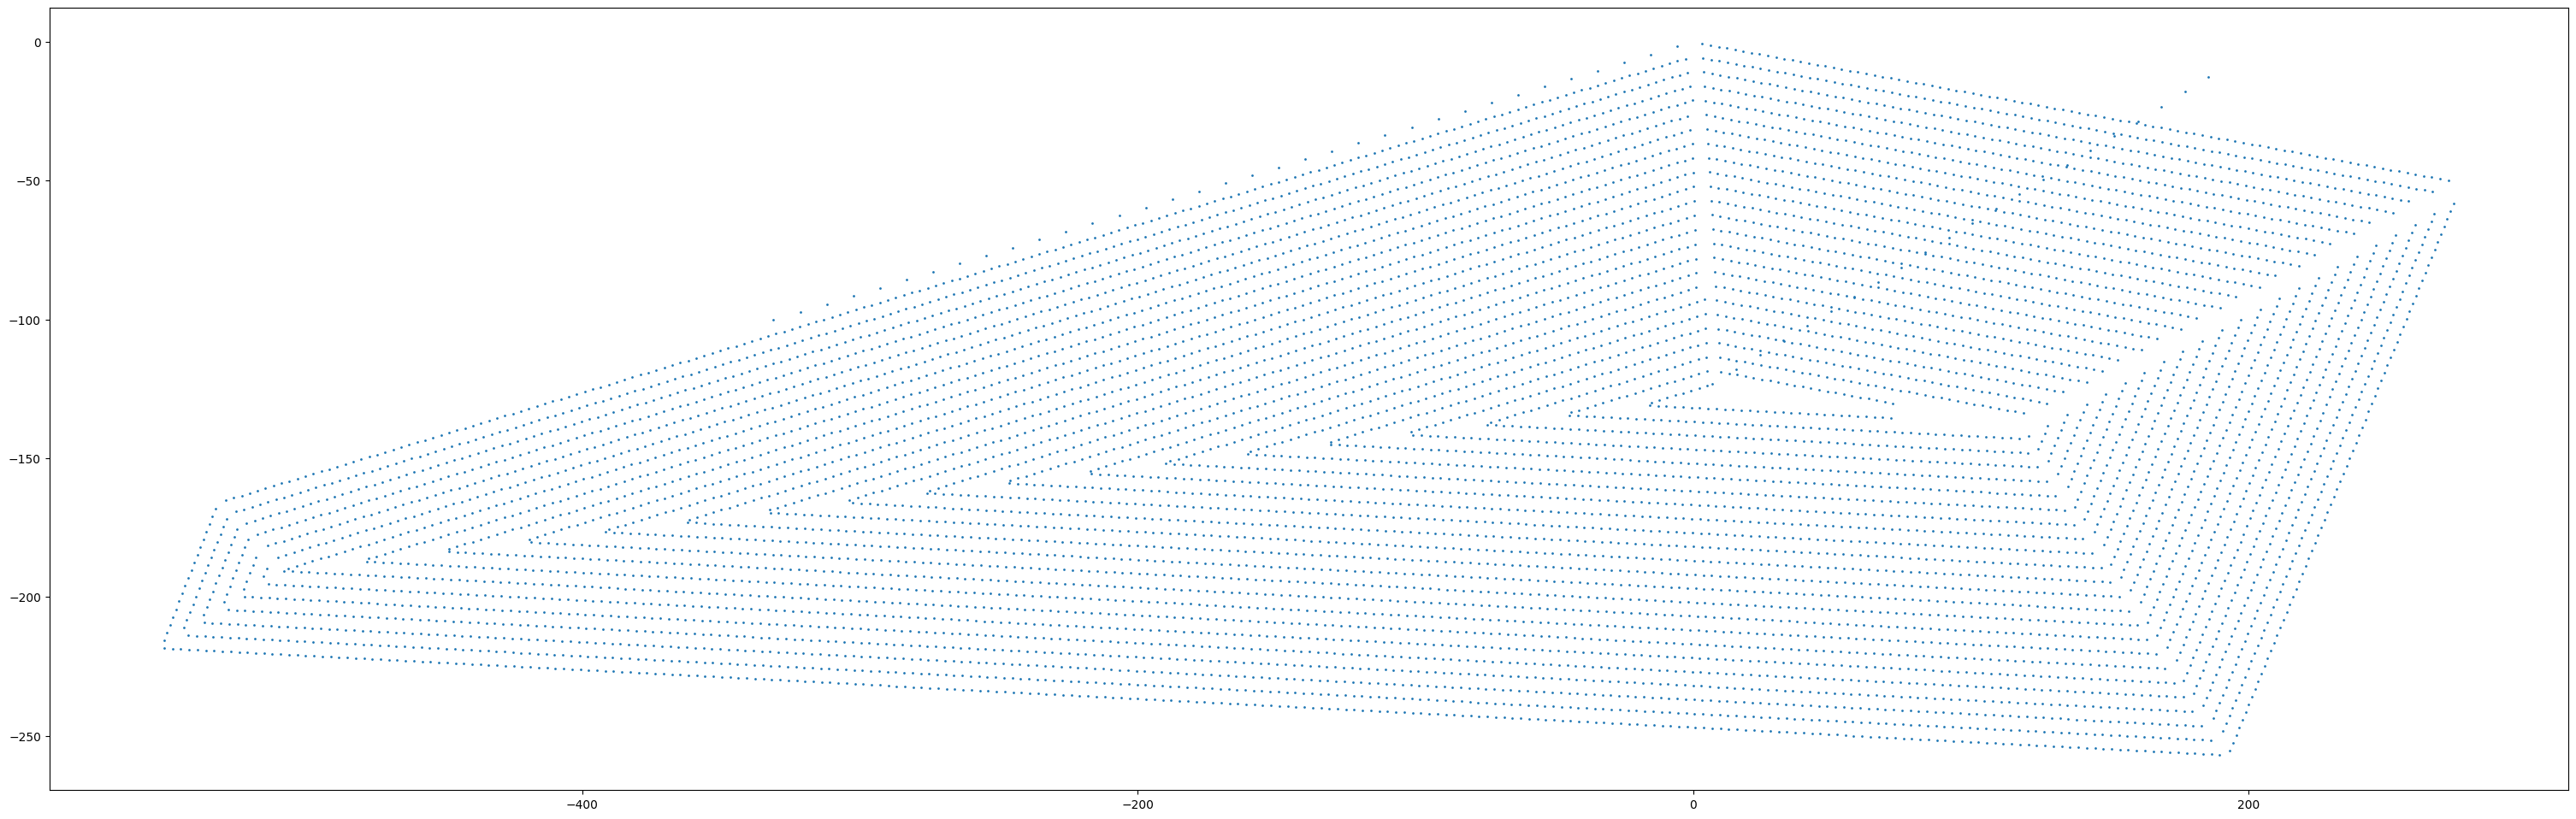

In [22]:
#Разбиваем весь маршрут на отрезки с частотой посадки
for vertices1 in results1:
  # Вычисляем длины сторон и добавляем точки
  for i in range(0, len(vertices1)):
    dx = vertices1[(i+1)%len(vertices1)][0] - vertices1[i][0]
    dy = vertices1[(i+1)%len(vertices1)][1] - vertices1[i][1]
    length_side = math.sqrt(dx**2 + dy**2)

    for j in range(3, int(length_side), h):
        x = vertices1[i][0] + (j * dx / length_side)
        if i==0:
          y = vertices1[i][1] + distance + (j * dy / length_side)
        else:
          y = vertices1[i][1] + (j * dy / length_side)
        points_on_perimeter.append((x, y))

dx1 = results2[1][0] - results2[0][0]
dy1 = results2[1][1] - results2[0][1]
length_side1 = math.sqrt(dx1**2 + dy1**2)

for j1 in range(0, int(length_side1), 10):
  x = results2[0][0] + (j1 * dx1 / length_side1)
  y = results2[0][1] + (j1 * dy1 / length_side1)
  points_on_perimeter.append((x, y))


# Отрисовка точек на графике
fig, ax = plt.subplots(figsize=(38, 22))
plt.scatter([point[0] for point in points_on_perimeter], [point[1] for point in points_on_perimeter], s=1)
ax.set_aspect('equal', 'box')
plt.show()

Список координат точек получен!

# 3. Задача

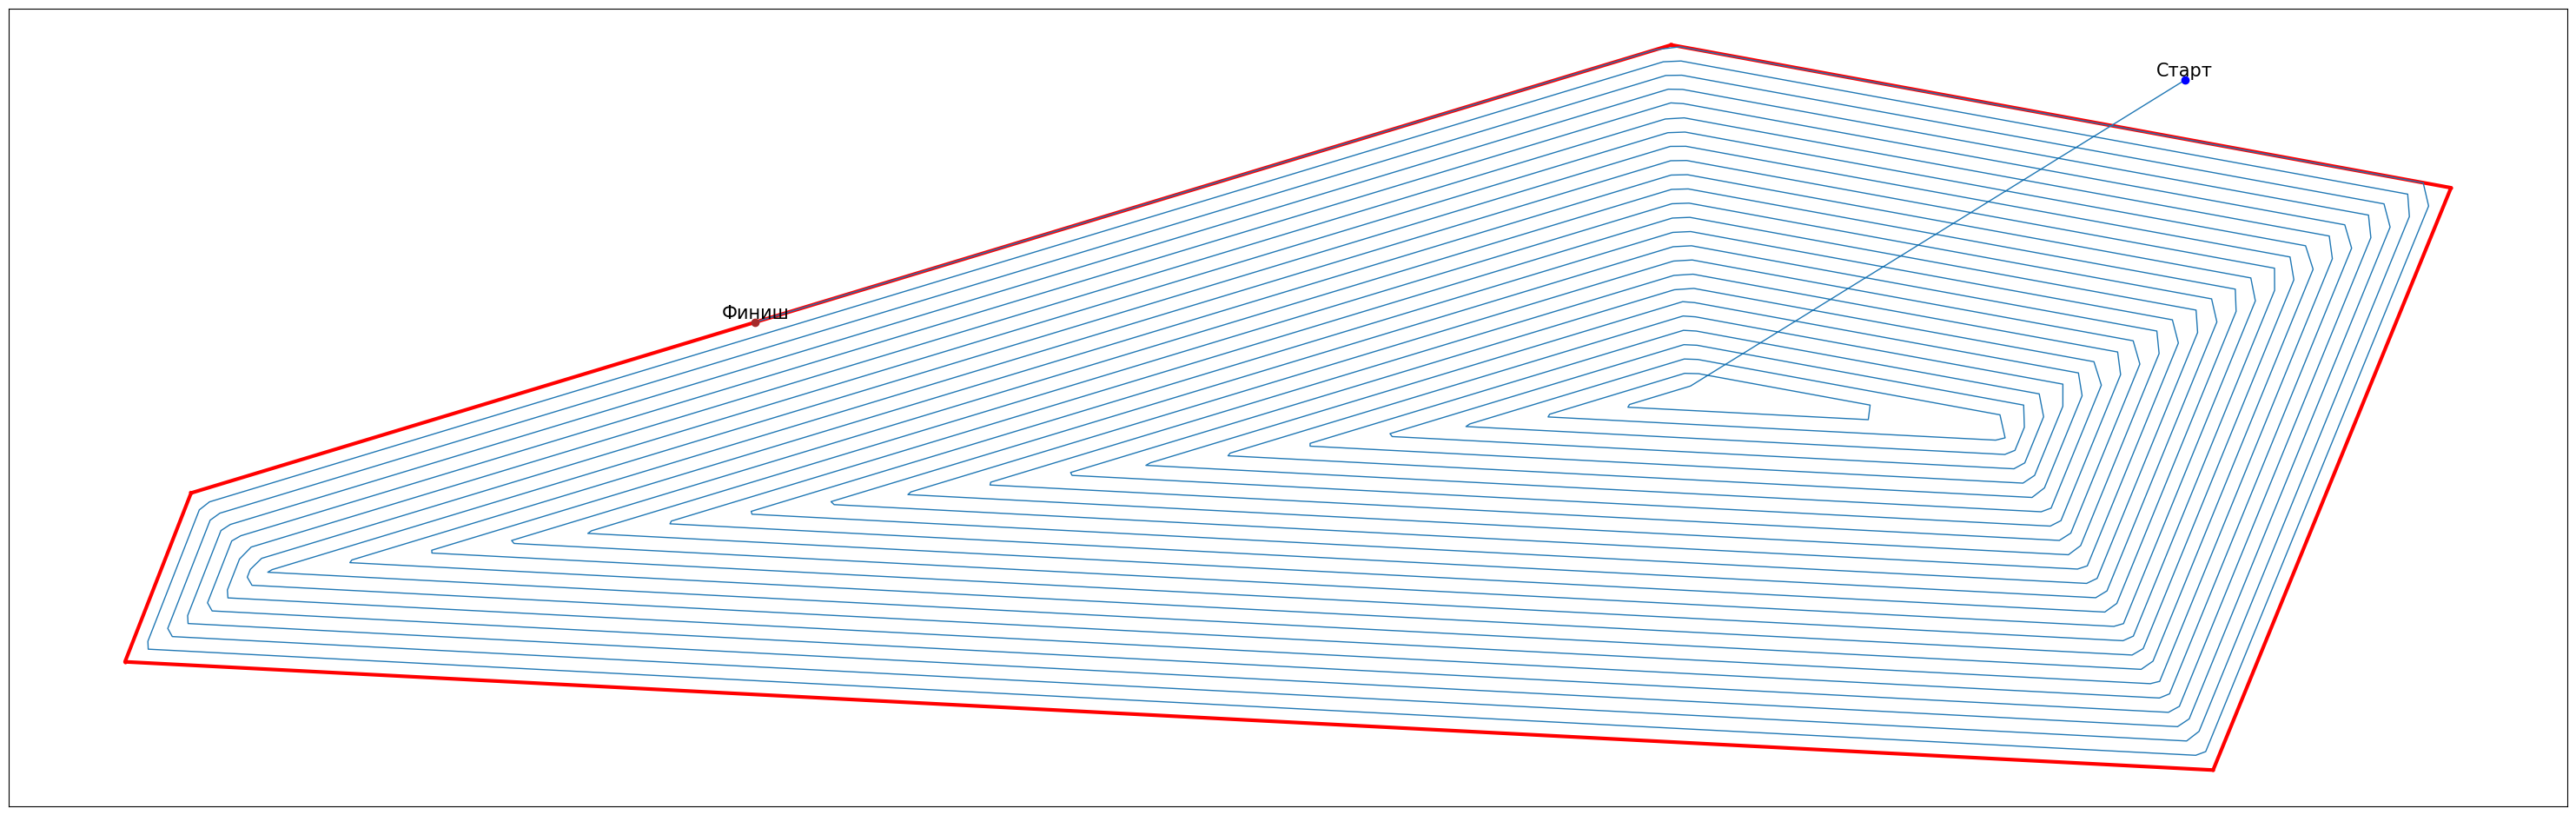

In [24]:
#Создаем нужную последовательность
reversed_points = list(reversed(points_on_perimeter))

# Отрисовка маршрута на графике
fig, ax = plt.subplots(figsize=(38, 22))
ax.plot([coord[0] for coord in ver], [coord[1] for coord in ver], marker='o', linestyle='-', color='red', linewidth=3, markersize=2)
ax.plot([ver[-1][0], ver[0][0]], [ver[-1][1], ver[0][1]], color='red', linestyle='-', linewidth=3)
# Соединяем точки линиями
plt.plot([point[0] for point in reversed_points], [point[1] for point in reversed_points], linewidth=1)

ax.plot(reversed_points[0][0], reversed_points[0][1], marker='o', linestyle='-', color='blue', markersize=6)
ax.text(reversed_points[0][0], reversed_points[0][1], "Cтарт", fontsize=15, color='black', horizontalalignment='center', verticalalignment='bottom')
ax.plot(reversed_points[-1][0], reversed_points[-1][1], marker='o', linestyle='-', color='brown', markersize=6)
ax.text(reversed_points[-1][0], reversed_points[-1][1], "Финиш", fontsize=15, color='black', horizontalalignment='center', verticalalignment='bottom')
# Убираем метки на осях X и Y
plt.xticks([])
plt.yticks([])

# Устанавливаем одинаковый масштаб по осям
ax.set_aspect('equal', 'box')

plt.show()

Все готово!


**Спасибо за внимание!!!**